In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10,7)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

## Checking the unbiased step-size trick

In [38]:
def estimate_mean_exp(samples, step_sizes):
    """computes the exponential recency-weighted mean"""
    mean_exp = np.zeros(samples.shape)
    mean_exp[0] = samples[0]
    for i in range(1, samples.size):
        mean_exp[i] = mean_exp[i-1] + step_sizes[i-1] * (samples[i] - mean_exp[i-1])
    return mean_exp

def estimate_and_plot(samples, step_sizes, title=''):
    mean_uni = np.mean(samples)
    print(f'Unweighted mean: {mean_uni}')
    mean_exp_all = estimate_mean_exp(samples, step_sizes)
    print(f'Final estimate: {mean_exp_all[-1]}')
    
    plt.plot(mean_exp_all, label='exp recency-weighted average')
    plt.axhline(mean_uni, color='orange', ls='--', label='sample average')
    plt.legend()
    plt.title(title)
    plt.show()

In [31]:
# generate samples

np.random.seed(0)
samples = np.random.normal(0, 2, 500)

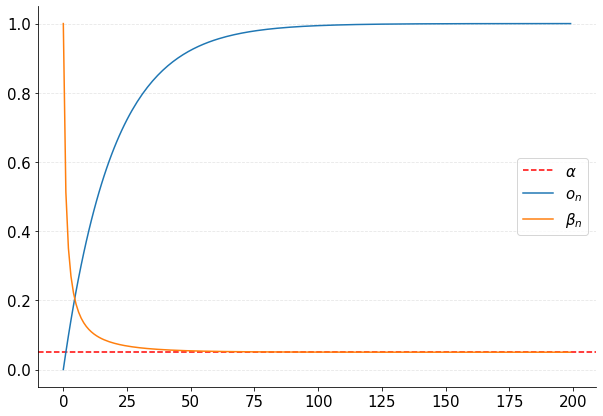

In [34]:
# generate step sizes

alpha = 0.05

# constant step sizes
step_sizes_constant = np.ones(samples.shape) * alpha

# unbiased step sizes 
o = np.zeros(samples.shape)
for i in range(1, o.size):
    o[i] = o[i-1] + alpha * (1 - o[i-1])
step_sizes_unbiased = alpha / o[1:]

# visualize the step sizes
first_n = 200
plt.axhline(alpha, color='red', ls='--', label=r'$\alpha$')
plt.plot(o[:first_n], label=r'$o_n$')
plt.plot(step_sizes_unbiased[:first_n], label=r'$\beta_n$')
plt.legend()
plt.grid(axis='y', alpha=0.3, ls='--')

Unweighted mean: -0.05070887866486765
Final estimate: 0.10715506200252743


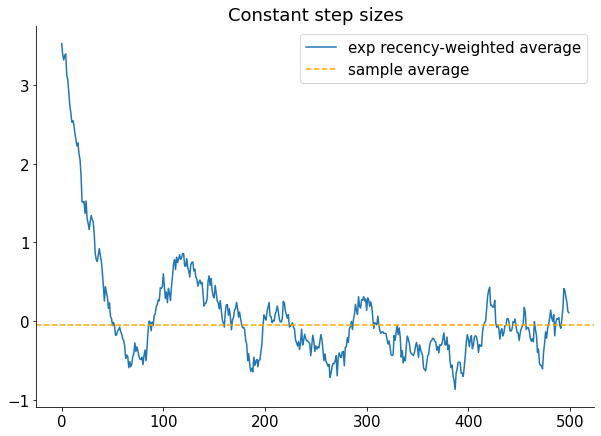

In [40]:
estimate_and_plot(samples, step_sizes_constant, title='Constant step sizes')

Unweighted mean: -0.05070887866486765
Final estimate: 0.10715506197633203


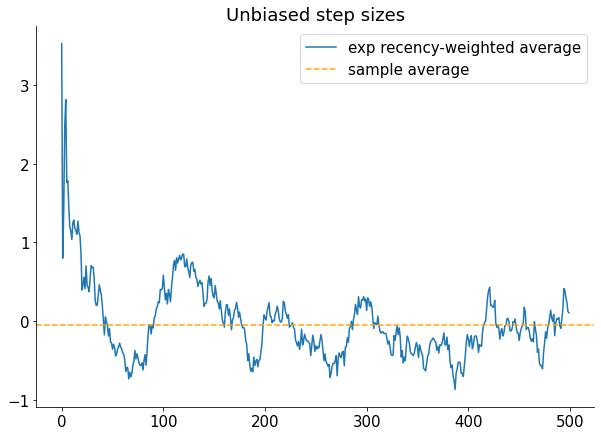

In [41]:
estimate_and_plot(samples, step_sizes_unbiased, title='Unbiased step sizes')

The difference is only at the very beginning (when the step sizes are actually different). The final estimates are practically the same.

What if the initial estimate (which is equal to the first sample) is really skewed?

In [42]:
samples[0] = 100

Unweighted mean: 0.14223491195126167
Final estimate: 0.10715506274124742


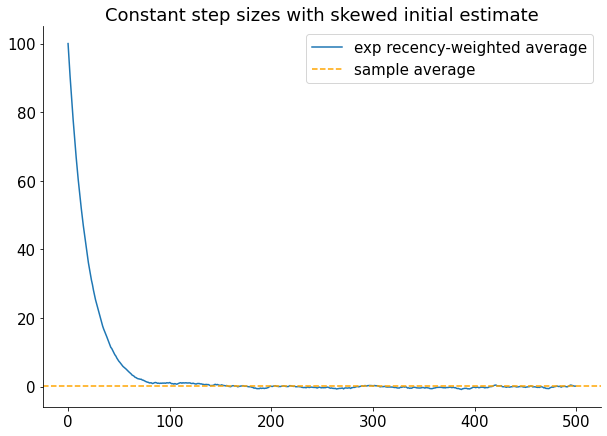

In [44]:
estimate_and_plot(samples, step_sizes_constant, title='Constant step sizes with skewed initial estimate')

Unweighted mean: 0.14223491195126167
Final estimate: 0.10715506197633203


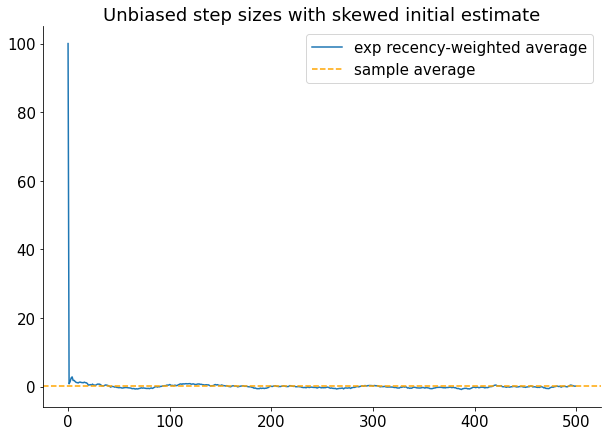

In [45]:
estimate_and_plot(samples, step_sizes_unbiased, title='Unbiased step sizes with skewed initial estimate')

Nope, the skewed initial estimate doesn't have a large effect on the final estimate in the above problem setting. The only thing to note is that the final estimates are exactly the same when using unbiased step sizes irrespective of the initial estimate, which is by design. This isn't the case when constant step sizes are used — the final estimate is affected by the initial estimate (albeit slightly).

Conclusion: the unbiased step-size trick is neat; it's utility may be significant when the initial estimates are arbitrarily bad and there are only a few samples.

## Linear Value-function Geometry

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


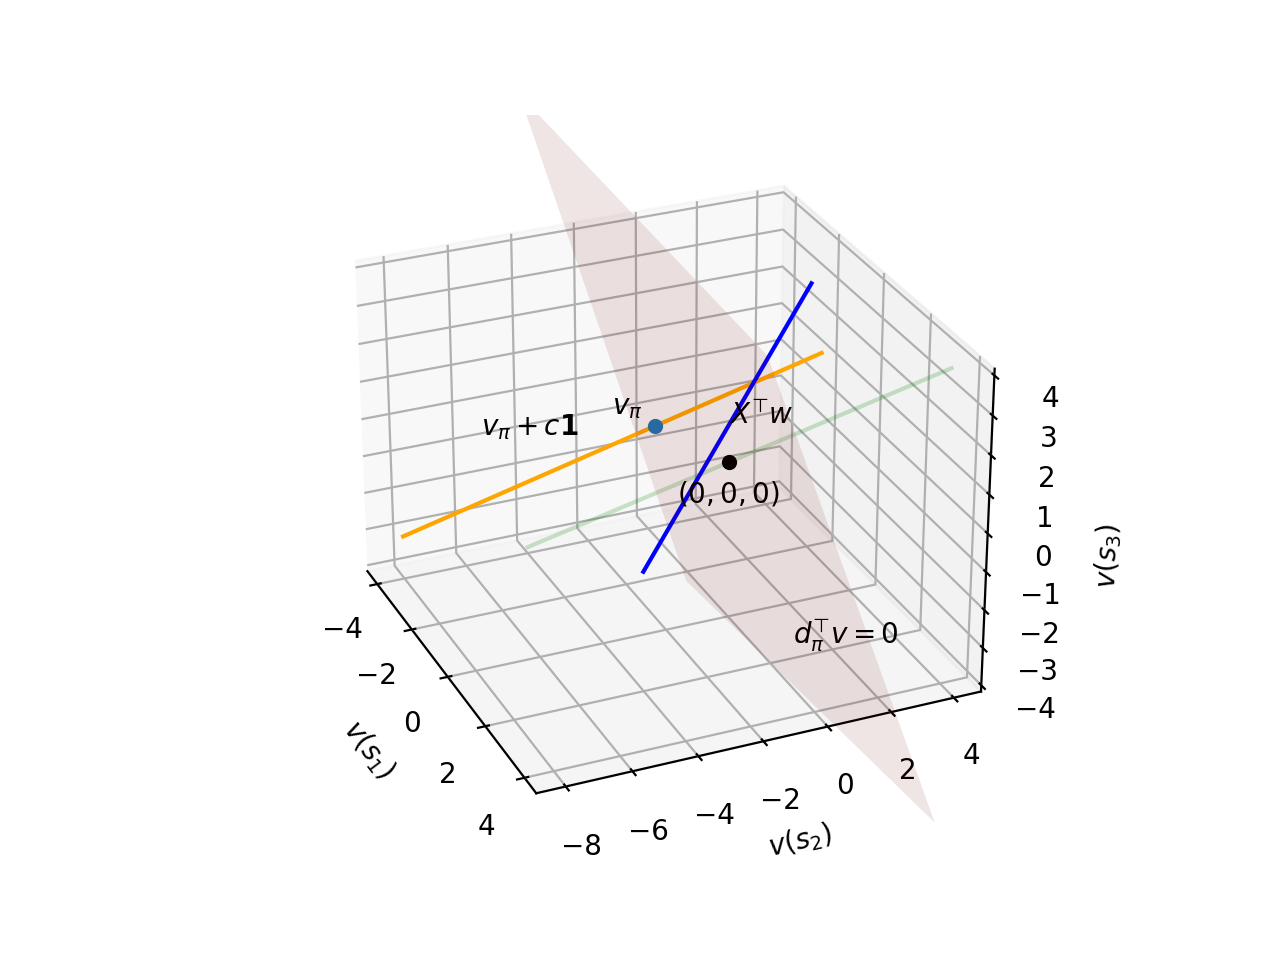

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(r'$v(s_1)$')
ax.set_ylabel(r'$v(s_2)$')
ax.set_zlabel(r'$v(s_3)$')

# point: origin
ax.scatter(0, 0, 0, color='black')
ax.text(-1, -1, -1.5, '$(0,0,0)$')

# point: v_pi
v_pi = [1, -3, 2]
ax.scatter(v_pi[0], v_pi[1], v_pi[2])
ax.text(v_pi[0]-0.8, v_pi[1]-0.8, v_pi[2], '$v_\pi$')

# line: v_pi + c1
x = np.linspace(-4, 4, 50)
y = v_pi[1] - v_pi[0] + x
z = v_pi[2] - v_pi[0] + x
ax.plot(x, y, z, color='orange')
ax.text(-3, -6, 0, '$v_\pi + c\mathbf{1}$')

# line: c1
ax.plot(x, x, x, color='green', alpha=0.2)

# plane: a representable plane
# y = np.linspace(-4, 4, 50)
# x_, y_ = np.meshgrid(x, y)
# z = -0.6 * x_ + 0.2 * y_ + 1
# ax.plot_surface(x_, y_, z, color='blue', alpha=0.1)

# line along the plane: even lesser parameters
x = np.linspace(-2, 2, 50)
y = -2 * x
z = -1 * x + 1
ax.plot(x, y, z, color='blue')
ax.text(0, 0, 1, r'$X^\top w$')

# plane: d_pi^T v = 0 (assuming d_pi = 1)
x = np.linspace(-4, 4, 50)
y = np.linspace(-4, 4, 50)
x_, y_ = np.meshgrid(x, y)
z = - x_ - y_
ax.plot_surface(x_, y_, z, color='red', alpha=0.1)
ax.text(3, 0, -3, r'$d_\pi^\top v = 0$')

ax.set_zlim(-4, 4)

plt.show()

I will do some more analysis when required.

## Checking the $\mathbf{A}$ matrix for off-policy tabular DiffTD($\lambda$)

\begin{align*}
\mathbf{A} &=
            \begin{bmatrix}
                \eta & \eta\, \mathbf{d}_b^\top (\mathbb{I} - \mathbf{P}_\pi) \mathbf{X} \\
                \frac{1}{1-\lambda} \mathbf{X}^\top \mathbf{D}_b \mathbb{1} & \sum_{k=0}^\infty \lambda^k \mathbf{X}^\top \mathbf{D}_b \mathbf{P}_\pi^k (\mathbb{I} - \mathbf{P}_\pi) \mathbf{X}
           \end{bmatrix}_{(d+1)\times(d+1)}
\end{align*}

1. First I choose an environment and a target policy. That gives me $\mathbf{X}$ and $\mathbf{P}_\pi$.
2. Then I choose a behaviour policy and get $\mathbf{D}_b$.
3. After specifying the problem, now I specify the solution parameters $\eta$, $\lambda$.

I need to check the real parts of the eigenvalues of $\mathbf{A}$ for different combinations of $b$, $\lambda$.

- Environment: RW5. So $\mathbf{X} = \mathbf{I}_5$.
- $\pi$: left and right with equal probability 0.5. 

In [65]:
def get_X(num_states=5, debug=False):
    X = np.eye(num_states)
    if debug:
        print(f'X=\n{X}')
    return X

def get_P_pi(pi=[0.5, 0.5], num_states=5, debug=False):
    P_pi = np.array([
        [0.0, pi[1], pi[0], 0.0, 0.0],
        [pi[0], 0.0, pi[1], 0.0, 0.0],
        [0.0, pi[0], 0.0, pi[1], 0.0],
        [0.0, 0.0, pi[0], 0.0, pi[1]],
        [0.0, 0.0, pi[1], pi[0], 0.0],
    ])
    if debug:
        print(f'P_pi=\n{P_pi}')
    return P_pi

- b: [0.4, 0.6].

In [31]:
def compute_Pb_Db(b, debug=False):
    P_b = np.array([
        [0.0, b[1], b[0], 0.0, 0.0],
        [b[0], 0.0, b[1], 0.0, 0.0],
        [0.0, b[0], 0.0, b[1], 0.0],
        [0.0, 0.0, b[0], 0.0, b[1]],
        [0.0, 0.0, b[1], b[0], 0.0],
    ])

    P_b_inf = P_b.copy()
    for i in range(10):
        P_b_inf = np.matmul(P_b_inf, P_b_inf)
    d_b = P_b_inf[0]
    D_b = np.multiply(P_b_inf, np.eye(5))

    if debug:
        print(f'P_b=\n{P_b}\nP_b_inf=\n{P_b_inf}\nD_b=\n{D_b}\n')
    
    return P_b, D_b, d_b

### Constructing A, part-by-part

- $\eta = 0.5$
- $\lambda = 0.5$

Recall $\mathbf{P}_\pi^\lambda = (1-\lambda) \sum_{k=0}^\infty \lambda^k \mathbf{P}_\pi^{k+1}$, so the lower-right matrix of $\mathbf{A}$ is $\mathbf{X}^\top \mathbf{D}_b (\mathbb{I} - \mathbf{P}_\pi^\lambda) \mathbf{X}$

In [45]:
def compute_A(P_pi, X, D_b, d_b, eta, lamda, all_of_A=True, debug=False):
    states, dims = X.shape
    A = np.zeros((dims+1, dims+1))

    # left-top scalar
    left_top_scalar = eta
    A[0,0] = left_top_scalar

    # right-top vector
    I_P_X = np.matmul(np.identity(5) - P_pi, X)
    right_top_vec = eta * np.dot(d_b, I_P_X)
    A[0,1:] = right_top_vec

    # left-bottom vector
    left_bottom_vec = 1/(1-lamda) * np.matmul(X.T, d_b)
    A[1:,0] = left_bottom_vec.T

    # right-bottom matrix
    P_pi_lambda = P_pi.copy()
    P_pi_t = P_pi.copy()
    for i in range(100):
        P_pi_t = np.matmul(P_pi_t, P_pi)
        P_pi_lambda += lamda**(i+1) * P_pi_t
    P_pi_lambda *= (1 - lamda)
    I_Pl_X = np.matmul(np.identity(states) - P_pi_lambda, X)
    X_D = np.matmul(X.T, D_b)
    bottom_right_matrix = np.matmul(X_D, I_Pl_X)
    A[1:,1:] = bottom_right_matrix
    
    if not all_of_A:
        A = bottom_right_matrix
    
    if debug:
        print(f'A=\n{A}')
    
    return A

$\mathbf{LA}$

In [33]:
def compute_LA(l, A, debug=False):
    L = np.identity(A.shape[0])
    L[0,0] = l
    LA = np.matmul(L, A)

    if debug:
        print(f'LA=\n{LA}\n')
    
    return LA

#### Center X

In [42]:
def compute_centered_X(X, d, debug=False):
    avg_feature = np.dot(d, X)
    centered_X = X - avg_feature
    
    if debug:
        print(f'Centered X = {centered_X}')
    return centered_X

X = np.identity(3)
d_b = np.array([0.2, 0.5, 0.3])
centered_X = compute_centered_X(X, d_b)
print(centered_X)
X = centered_X[:,:-1]
print(X)

[[ 0.8 -0.5 -0.3]
 [-0.2  0.5 -0.3]
 [-0.2 -0.5  0.7]]
[[ 0.8 -0.5]
 [-0.2  0.5]
 [-0.2 -0.5]]


## Trying combinations of $\lambda$ and $b$

In [66]:
def check_evals(num_states=5, b=[0.5, 0.5], eta=0.5, l=10.0, pi=[0.5, 0.5],
                lambdas=np.arange(10)/10.0, all_of_A=True,
                center_X=False, debug=False):

    X = get_X(num_states=num_states, debug=debug)
    P_pi = get_P_pi(pi=pi, num_states=num_states, debug=debug)
    P_b, D_b, d_b = compute_Pb_Db(b, debug=debug)
    
    if center_X:
        centered_X = compute_centered_X(X, d_b, debug=debug)
        X = centered_X[:,:-1]

    for lamda in lambdas:
        A = compute_A(X=X, P_pi=P_pi, D_b=D_b, d_b=d_b, eta=eta, lamda=lamda, all_of_A=all_of_A, debug=debug)
        LA = compute_LA(l=l, A=A, debug=debug)
        evals, _ = np.linalg.eig(LA)
        
        # positive = np.all(evals.real >= 0)
        # print(f'lambda={lamda}: {evals.real} {positive}')
        print(f'lambda={lamda}: (real) {evals.real}, (imag) {evals.imag}')

### Only lower-right part of A (i.e., keeping the reward-rate estimate fixed)

In [186]:
check_evals_real_part(b=[0.5, 0.5], all_of_A=False)

lambda=0.0: [1.164 0.491 0.    0.101 0.243] True
lambda=0.1: [ 1.137  0.458 -0.     0.105  0.235] False
lambda=0.2: [1.111 0.43  0.    0.108 0.227] True
lambda=0.3: [1.088 0.405 0.    0.221 0.112] True
lambda=0.4: [ 1.067  0.382 -0.     0.216  0.115] False
lambda=0.5: [1.049 0.362 0.    0.212 0.119] True
lambda=0.6: [1.033 0.    0.122 0.21  0.344] True
lambda=0.7: [ 1.022 -0.     0.125  0.21   0.328] False
lambda=0.8: [1.015 0.    0.313 0.212 0.127] True
lambda=0.9: [1.012 0.    0.128 0.3   0.216] True


In [187]:
check_evals_real_part(b=[0.6, 0.4], all_of_A=False)

lambda=0.0: [ 1.645  0.493 -0.     0.086  0.197] False
lambda=0.1: [1.604 0.461 0.    0.088 0.192] True
lambda=0.2: [ 1.567  0.434  0.189 -0.     0.089] False
lambda=0.3: [1.533 0.409 0.187 0.    0.09 ] True
lambda=0.4: [ 1.503  0.387  0.186 -0.     0.092] False
lambda=0.5: [1.478 0.368 0.    0.187 0.092] True
lambda=0.6: [1.457 0.35  0.    0.189 0.093] True
lambda=0.7: [1.44  0.335 0.    0.192 0.093] True
lambda=0.8: [1.43  0.    0.092 0.197 0.32 ] True
lambda=0.9: [1.427 0.    0.092 0.203 0.308] True


In [188]:
check_evals_real_part(b=[0.7, 0.3], all_of_A=False)

lambda=0.0: [2.143 0.497 0.156 0.064 0.   ] True
lambda=0.1: [ 2.089  0.467  0.155 -0.     0.064] False
lambda=0.2: [2.04  0.44  0.155 0.    0.064] True
lambda=0.3: [1.996 0.416 0.156 0.    0.064] True
lambda=0.4: [ 1.958  0.395  0.158 -0.     0.063] False
lambda=0.5: [ 1.924  0.377  0.161 -0.     0.063] False
lambda=0.6: [ 1.897  0.36   0.164 -0.     0.062] False
lambda=0.7: [1.877 0.345 0.169 0.    0.061] True
lambda=0.8: [1.863 0.332 0.174 0.    0.06 ] True
lambda=0.9: [1.859 0.    0.059 0.18  0.321] True


### All of A

In [13]:
check_evals(b=[0.5, 0.5])

lambda=0.0: (real) [ 0.469 -0.     0.07   0.197  0.263  5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 0.443 -0.     0.074  0.19   0.252  5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [0.419 0.    0.077 0.183 0.243 5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [0.397 0.    0.081 0.235 0.176 5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [ 0.378 -0.     0.085  0.228  0.17   5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [ 0.36  -0.     0.089  0.222  0.165  5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [0.    0.093 0.16  0.218 0.343 5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [0.    0.098 0.155 0.215 0.328 5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [0.    0.315 0.103 0.215 0.15  5.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [0.    0.107 0.146 0.302 0.217 5.   ], (imag) [0. 0. 0. 0. 0. 0.]


In [14]:
check_evals(b=[0.6, 0.4])

lambda=0.0: (real) [ 5.003  0.473  0.289 -0.     0.175  0.06 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.003  0.446  0.277 -0.     0.062  0.17 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.004 0.422 0.266 0.    0.064 0.166], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.004 0.401 0.    0.256 0.066 0.163], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.005 0.382 0.    0.246 0.067 0.16 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.006 0.364 0.    0.238 0.069 0.159], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [ 5.007  0.349 -0.     0.069  0.23   0.159], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.01   0.335 -0.     0.069  0.223  0.161], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.015 0.323 0.    0.066 0.215 0.164], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.03  0.314 0.    0.055 0.201 0.174], (imag) [0. 0. 0. 0. 0. 0.]


In [15]:
check_evals(b=[0.7, 0.3])

lambda=0.0: (real) [ 5.011  0.481  0.335 -0.     0.038  0.135], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.012  0.454  0.321 -0.     0.038  0.133], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.014 0.431 0.309 0.    0.038 0.13 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.016 0.41  0.298 0.    0.038 0.128], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [ 5.019  0.391  0.288 -0.     0.037  0.127], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [ 5.022  0.374  0.279 -0.     0.036  0.126], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.028 0.359 0.271 0.    0.034 0.124], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.038  0.346  0.264 -0.     0.03   0.121], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.056 0.335 0.259 0.    0.019 0.115], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [ 5.112 -0.021 -0.     0.1    0.255  0.328], (imag) [0. 0. 0. 0. 0. 0.]


In [16]:
check_evals(b=[0.8, 0.2])

lambda=0.0: (real) [ 5.024  0.49   0.379  0.09  -0.     0.017], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.026  0.464  0.365  0.088 -0.     0.017], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [ 5.029  0.441  0.352  0.085 -0.     0.016], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.034 0.42  0.34  0.083 0.    0.015], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [ 5.039  0.401  0.33   0.08  -0.     0.014], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [ 5.047 -0.     0.011  0.076  0.321  0.384], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [ 5.059 -0.     0.007  0.07   0.313  0.369], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.079  0.356  0.307  0.061 -0.001 -0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [ 5.118 -0.027 -0.     0.049  0.303  0.344], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [ 5.231 -0.129 -0.     0.038  0.301  0.336], (imag) [0. 0. 0. 0. 0. 0.]


In [17]:
check_evals(b=[0.9, 0.1])

lambda=0.0: (real) [5.039 0.044 0.    0.004 0.417 0.497], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.043  0.041 -0.     0.004  0.401  0.472], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.048 0.038 0.    0.003 0.387 0.449], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.055 0.034 0.    0.002 0.374 0.428], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [ 5.065  0.028 -0.     0.     0.363  0.409], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [ 5.077  0.022 -0.003 -0.     0.354  0.392], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [ 5.097 -0.013  0.015  0.     0.346  0.377], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.128 -0.038  0.011  0.     0.34   0.363], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [ 5.191 -0.095  0.009 -0.     0.335  0.35 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [ 5.37  -0.268 -0.     0.008  0.331  0.34 ], (imag) [0. 0. 0. 0. 0. 0.]


In [63]:
check_evals(b=[0.95, 0.05])

lambda=0.0: (real) [ 5.047  0.021 -0.     0.001  0.432  0.499], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.052  0.018 -0.     0.001  0.415  0.474], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.058 0.014 0.    0.    0.4   0.452], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [ 5.067  0.01  -0.001 -0.     0.387  0.432], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [ 5.078  0.376  0.413 -0.005  0.005  0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [ 5.093  0.366  0.396 -0.015  0.003 -0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [ 5.116 -0.034  0.003 -0.     0.357  0.38 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.155 -0.067  0.002 -0.     0.35   0.366], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [ 5.229 -0.137  0.002 -0.     0.345  0.353], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [ 5.441 -0.342  0.002 -0.     0.34   0.34 ], (imag) [ 0.     0.     0.     0.     0.001 -0.001]


In [64]:
check_evals(b=[0.99, 0.01])

lambda=0.0: (real) [5.053 0.443 0.004 0.    0.    0.5  ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.059  0.425  0.001 -0.    -0.     0.476], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [ 5.067  0.409 -0.004  0.     0.     0.454], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [ 5.076  0.395  0.434 -0.011  0.     0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [ 5.089  0.383  0.416 -0.02   0.     0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [ 5.106  0.372  0.399 -0.034  0.    -0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [ 5.133  0.363  0.384 -0.056  0.     0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.176 -0.093  0.355  0.369  0.     0.   ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [ 5.26  -0.171  0.    -0.     0.348  0.356], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [ 5.498 -0.401  0.    -0.     0.342  0.344], (imag) [0. 0. 0. 0. 0. 0.]


In [67]:
check_evals(b=[0.9, 0.1], pi=[0.1, 0.9])

lambda=0.0: (real) [ 5.076  0.432  0.432  0.055 -0.     0.005], (imag) [ 0.     0.089 -0.089  0.     0.     0.   ]
lambda=0.1: (real) [5.085 0.423 0.423 0.049 0.    0.004], (imag) [ 0.     0.086 -0.086  0.     0.     0.   ]
lambda=0.2: (real) [5.096 0.413 0.413 0.043 0.    0.002], (imag) [ 0.     0.082 -0.082  0.     0.     0.   ]
lambda=0.3: (real) [ 5.109  0.403  0.403  0.035  0.    -0.001], (imag) [ 0.     0.077 -0.077  0.     0.     0.   ]
lambda=0.4: (real) [ 5.128  0.393  0.393  0.026 -0.008 -0.   ], (imag) [ 0.    0.07 -0.07  0.    0.    0.  ]
lambda=0.5: (real) [ 5.153  0.384  0.384 -0.022  0.018  0.   ], (imag) [ 0.     0.062 -0.062  0.     0.     0.   ]
lambda=0.6: (real) [ 5.191  0.374  0.374 -0.05   0.013  0.   ], (imag) [ 0.     0.053 -0.053  0.     0.     0.   ]
lambda=0.7: (real) [ 5.253  0.365  0.365 -0.104 -0.     0.011], (imag) [ 0.     0.042 -0.042  0.     0.     0.   ]
lambda=0.8: (real) [ 5.373 -0.213  0.355  0.355 -0.     0.009], (imag) [ 0.    0.    0.03 -0.03  0

In [68]:
check_evals(b=[0.99, 0.01], pi=[0.01, 0.99])

lambda=0.0: (real) [5.106 0.444 0.444 0.005 0.    0.   ], (imag) [ 0.     0.155 -0.155  0.     0.     0.   ]
lambda=0.1: (real) [ 5.117  0.44   0.44  -0.002  0.001  0.   ], (imag) [ 0.     0.143 -0.143  0.     0.     0.   ]
lambda=0.2: (real) [ 5.131  0.433  0.433 -0.011  0.     0.   ], (imag) [ 0.    0.13 -0.13  0.    0.    0.  ]
lambda=0.3: (real) [ 5.15   0.425  0.425 -0.024  0.    -0.   ], (imag) [ 0.     0.116 -0.116  0.     0.     0.   ]
lambda=0.4: (real) [ 5.175  0.415  0.415 -0.043  0.     0.   ], (imag) [ 0.     0.101 -0.101  0.     0.     0.   ]
lambda=0.5: (real) [ 5.209  0.405  0.405 -0.071 -0.     0.   ], (imag) [ 0.     0.085 -0.085  0.     0.     0.   ]
lambda=0.6: (real) [ 5.261  0.394  0.394 -0.114  0.     0.   ], (imag) [ 0.     0.069 -0.069  0.     0.     0.   ]
lambda=0.7: (real) [ 5.344  0.382  0.382 -0.187  0.     0.   ], (imag) [ 0.     0.052 -0.052  0.     0.     0.   ]
lambda=0.8: (real) [ 5.504 -0.332  0.369  0.369 -0.     0.   ], (imag) [ 0.     0.     0.035

In [73]:
check_evals(b=[0.95, 0.05], pi=[0.001, 0.999], lambdas=[0.0], debug=True)

X=
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
P_pi=
[[0.    0.999 0.001 0.    0.   ]
 [0.001 0.    0.999 0.    0.   ]
 [0.    0.001 0.    0.999 0.   ]
 [0.    0.    0.001 0.    0.999]
 [0.    0.    0.999 0.001 0.   ]]
P_b=
[[0.   0.05 0.95 0.   0.  ]
 [0.95 0.   0.05 0.   0.  ]
 [0.   0.95 0.   0.05 0.  ]
 [0.   0.   0.95 0.   0.05]
 [0.   0.   0.05 0.95 0.  ]]
P_b_inf=
[[0.316 0.332 0.333 0.017 0.001]
 [0.316 0.332 0.333 0.017 0.001]
 [0.316 0.332 0.333 0.017 0.001]
 [0.316 0.332 0.333 0.017 0.001]
 [0.316 0.332 0.333 0.017 0.001]]
D_b=
[[0.316 0.    0.    0.    0.   ]
 [0.    0.332 0.    0.    0.   ]
 [0.    0.    0.333 0.    0.   ]
 [0.    0.    0.    0.017 0.   ]
 [0.    0.    0.    0.    0.001]]

A=
[[ 0.5    0.158  0.008 -0.    -0.158 -0.008]
 [ 0.316  0.316 -0.316 -0.     0.     0.   ]
 [ 0.332 -0.     0.332 -0.332  0.     0.   ]
 [ 0.333  0.    -0.     0.333 -0.333  0.   ]
 [ 0.017  0.     0.    -0.     0.017 -0.017]
 [ 0.001  0. 

In [76]:
check_evals(b=[0.999, 0.001], pi=[0.001, 0.999], lambdas=[0.0], center_X=False)

lambda=0.0: (real) [ 5.123  0.266  0.266 -0.081  0.    -0.   ], (imag) [ 0.     0.074 -0.074  0.     0.     0.   ]


In [75]:
check_evals(b=[0.999, 0.001], pi=[0.001, 0.999], lambdas=[0.0], center_X=True)

lambda=0.0: (real) [5.    0.269 0.269 0.    0.001], (imag) [ 0.     0.097 -0.097  0.     0.   ]


Observations:
- Not sure why all the imaginary parts are zero. 
- One of the eigenvalues is negative for larger lambdas as the behaviour policy diverges from the target policy. While this observation is consistent with $\lambda \rho_{max} > 1$, that cannot be the reason because the $A$ matrix does not involve $\rho$, only $d_b$.

### When X is mean-centered

In [46]:
check_evals(b=[0.5, 0.5], center_X=True, lambdas=[0.0], debug=True)

X=
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
P_pi=
[[0.  0.5 0.5 0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.5 0.5 0. ]]
P_b=
[[0.  0.5 0.5 0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.5 0.5 0. ]]
P_b_inf=
[[0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]]
D_b=
[[0.111 0.    0.    0.    0.   ]
 [0.    0.222 0.    0.    0.   ]
 [0.    0.    0.333 0.    0.   ]
 [0.    0.    0.    0.222 0.   ]
 [0.    0.    0.    0.    0.111]]

Centered X = [[ 0.889 -0.222 -0.333 -0.222 -0.111]
 [-0.111  0.778 -0.333 -0.222 -0.111]
 [-0.111 -0.222  0.667 -0.222 -0.111]
 [-0.111 -0.222 -0.333  0.778 -0.111]
 [-0.111 -0.222 -0.333 -0.222  0.889]]
A=
[[ 0.5    0.     0.    -0.     0.   ]
 [ 0.     0.111 -0.056 -0.056  0.   ]
 [ 0.    -0.111  0.222 -0.111  0.

In [47]:
check_evals(b=[0.5, 0.5], center_X=False, lambdas=[0.0], debug=True)

X=
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
P_pi=
[[0.  0.5 0.5 0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.5 0.5 0. ]]
P_b=
[[0.  0.5 0.5 0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.5 0.5 0. ]]
P_b_inf=
[[0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]
 [0.111 0.222 0.333 0.222 0.111]]
D_b=
[[0.111 0.    0.    0.    0.   ]
 [0.    0.222 0.    0.    0.   ]
 [0.    0.    0.333 0.    0.   ]
 [0.    0.    0.    0.222 0.   ]
 [0.    0.    0.    0.    0.111]]

A=
[[ 0.5    0.     0.     0.     0.     0.   ]
 [ 0.111  0.111 -0.056 -0.056  0.     0.   ]
 [ 0.222 -0.111  0.222 -0.111  0.     0.   ]
 [ 0.333  0.    -0.167  0.333 -0.167  0.   ]
 [ 0.222  0.     0.    -0.111  0.222 -0.111]
 [ 0.111  0.     0.    -0.056 -0.056  0.111]]
LA=
[[ 5.     0.     0.     0.     0.     

In [77]:
check_evals(b=[0.5, 0.5], center_X=True)

lambda=0.0: (real) [5.    0.474 0.02  0.144 0.251], (imag) [0. 0. 0. 0. 0.]
lambda=0.1: (real) [5.    0.446 0.02  0.142 0.242], (imag) [0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.    0.421 0.021 0.14  0.234], (imag) [0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.    0.399 0.021 0.138 0.227], (imag) [0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.    0.379 0.022 0.137 0.221], (imag) [0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.    0.36  0.022 0.136 0.217], (imag) [0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.    0.344 0.023 0.135 0.214], (imag) [0. 0. 0. 0. 0.]
lambda=0.7: (real) [5.    0.328 0.023 0.134 0.213], (imag) [0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.    0.314 0.023 0.133 0.213], (imag) [0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.    0.024 0.301 0.132 0.216], (imag) [0. 0. 0. 0. 0.]


In [78]:
check_evals(b=[0.6, 0.4], center_X=True, debug=True, lambdas=[0.0])

X=
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
P_pi=
[[0.  0.5 0.5 0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.5 0.5 0. ]]
P_b=
[[0.  0.4 0.6 0.  0. ]
 [0.6 0.  0.4 0.  0. ]
 [0.  0.6 0.  0.4 0. ]
 [0.  0.  0.6 0.  0.4]
 [0.  0.  0.4 0.6 0. ]]
P_b_inf=
[[0.158 0.263 0.333 0.175 0.07 ]
 [0.158 0.263 0.333 0.175 0.07 ]
 [0.158 0.263 0.333 0.175 0.07 ]
 [0.158 0.263 0.333 0.175 0.07 ]
 [0.158 0.263 0.333 0.175 0.07 ]]
D_b=
[[0.158 0.    0.    0.    0.   ]
 [0.    0.263 0.    0.    0.   ]
 [0.    0.    0.333 0.    0.   ]
 [0.    0.    0.    0.175 0.   ]
 [0.    0.    0.    0.    0.07 ]]

Centered X = [[ 0.842 -0.263 -0.333 -0.175 -0.07 ]
 [-0.158  0.737 -0.333 -0.175 -0.07 ]
 [-0.158 -0.263  0.667 -0.175 -0.07 ]
 [-0.158 -0.263 -0.333  0.825 -0.07 ]
 [-0.158 -0.263 -0.333 -0.175  0.93 ]]
A=
[[ 0.5    0.013  0.009  0.    -0.013]
 [-0.     0.154 -0.082 -0.079  0.004]
 [-0.    -0.139  0.259 -0.132  0.

In [54]:
check_evals(b=[0.6, 0.4], center_X=False)

lambda=0.0: (real) [ 5.003  0.473  0.289 -0.     0.175  0.06 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.1: (real) [ 5.003  0.446  0.277 -0.     0.062  0.17 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.004 0.422 0.266 0.    0.064 0.166], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.004 0.401 0.    0.256 0.066 0.163], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.005 0.382 0.    0.246 0.067 0.16 ], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.006 0.364 0.    0.238 0.069 0.159], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.6: (real) [ 5.007  0.349 -0.     0.069  0.23   0.159], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.7: (real) [ 5.01   0.335 -0.     0.069  0.223  0.161], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.015 0.323 0.    0.066 0.215 0.164], (imag) [0. 0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.03  0.314 0.    0.055 0.201 0.174], (imag) [0. 0. 0. 0. 0. 0.]


In [55]:
check_evals(b=[0.7, 0.3], center_X=True)

lambda=0.0: (real) [5.    0.008 0.481 0.335 0.125], (imag) [0. 0. 0. 0. 0.]
lambda=0.1: (real) [5.    0.008 0.455 0.321 0.124], (imag) [0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.    0.008 0.431 0.308 0.124], (imag) [0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.    0.008 0.41  0.297 0.124], (imag) [0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.    0.009 0.391 0.286 0.125], (imag) [0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.    0.009 0.126 0.276 0.374], (imag) [0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.    0.009 0.129 0.267 0.358], (imag) [0. 0. 0. 0. 0.]
lambda=0.7: (real) [5.    0.009 0.131 0.258 0.345], (imag) [0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.    0.009 0.135 0.25  0.333], (imag) [0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.    0.009 0.14  0.243 0.323], (imag) [0. 0. 0. 0. 0.]


In [56]:
check_evals(b=[0.8, 0.2], center_X=True)

lambda=0.0: (real) [5.    0.004 0.087 0.379 0.49 ], (imag) [0. 0. 0. 0. 0.]
lambda=0.1: (real) [5.    0.004 0.086 0.364 0.464], (imag) [0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.    0.004 0.086 0.35  0.441], (imag) [0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.    0.004 0.086 0.337 0.42 ], (imag) [0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.    0.004 0.086 0.326 0.401], (imag) [0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.    0.004 0.087 0.315 0.384], (imag) [0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.    0.004 0.088 0.306 0.369], (imag) [0. 0. 0. 0. 0.]
lambda=0.7: (real) [5.    0.004 0.09  0.297 0.355], (imag) [0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.    0.004 0.092 0.289 0.343], (imag) [0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.    0.004 0.094 0.281 0.334], (imag) [0. 0. 0. 0. 0.]


In [57]:
check_evals(b=[0.9, 0.1], center_X=True)

lambda=0.0: (real) [5.    0.001 0.043 0.416 0.497], (imag) [0. 0. 0. 0. 0.]
lambda=0.1: (real) [5.    0.001 0.043 0.399 0.472], (imag) [0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.    0.001 0.043 0.384 0.449], (imag) [0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.    0.001 0.042 0.371 0.428], (imag) [0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.    0.001 0.042 0.359 0.409], (imag) [0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.    0.001 0.043 0.348 0.392], (imag) [0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.    0.001 0.043 0.339 0.377], (imag) [0. 0. 0. 0. 0.]
lambda=0.7: (real) [5.    0.001 0.044 0.33  0.363], (imag) [0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.    0.001 0.045 0.322 0.351], (imag) [0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.    0.001 0.046 0.315 0.34 ], (imag) [0. 0. 0. 0. 0.]


In [59]:
check_evals(b=[0.95, 0.05], center_X=True)

lambda=0.0: (real) [5.    0.    0.021 0.431 0.499], (imag) [0. 0. 0. 0. 0.]
lambda=0.1: (real) [5.    0.    0.021 0.414 0.474], (imag) [0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.    0.    0.021 0.398 0.452], (imag) [0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.    0.    0.021 0.384 0.432], (imag) [0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.    0.    0.021 0.372 0.413], (imag) [0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.    0.    0.021 0.361 0.396], (imag) [0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.    0.    0.021 0.351 0.381], (imag) [0. 0. 0. 0. 0.]
lambda=0.7: (real) [5.    0.    0.021 0.342 0.366], (imag) [0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.    0.    0.022 0.335 0.353], (imag) [0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.    0.    0.022 0.328 0.342], (imag) [0. 0. 0. 0. 0.]


In [60]:
check_evals(b=[0.99, 0.01], center_X=True)

lambda=0.0: (real) [5.    0.    0.004 0.442 0.5  ], (imag) [0. 0. 0. 0. 0.]
lambda=0.1: (real) [5.    0.    0.004 0.424 0.476], (imag) [0. 0. 0. 0. 0.]
lambda=0.2: (real) [5.    0.    0.004 0.408 0.454], (imag) [0. 0. 0. 0. 0.]
lambda=0.3: (real) [5.    0.    0.004 0.393 0.434], (imag) [0. 0. 0. 0. 0.]
lambda=0.4: (real) [5.    0.    0.004 0.38  0.416], (imag) [0. 0. 0. 0. 0.]
lambda=0.5: (real) [5.    0.    0.004 0.369 0.399], (imag) [0. 0. 0. 0. 0.]
lambda=0.6: (real) [5.    0.    0.004 0.359 0.384], (imag) [0. 0. 0. 0. 0.]
lambda=0.7: (real) [5.    0.    0.004 0.35  0.369], (imag) [0. 0. 0. 0. 0.]
lambda=0.8: (real) [5.    0.    0.004 0.343 0.356], (imag) [0. 0. 0. 0. 0.]
lambda=0.9: (real) [5.    0.    0.004 0.336 0.344], (imag) [0. 0. 0. 0. 0.]


### Checking the approximation quality of a continuous differential equation

0.001 149.985
0.01 149.85
0.1 148.49999999999997
1.0 135.0
2.0 120.0
5.0 75.0
10.0 0.0


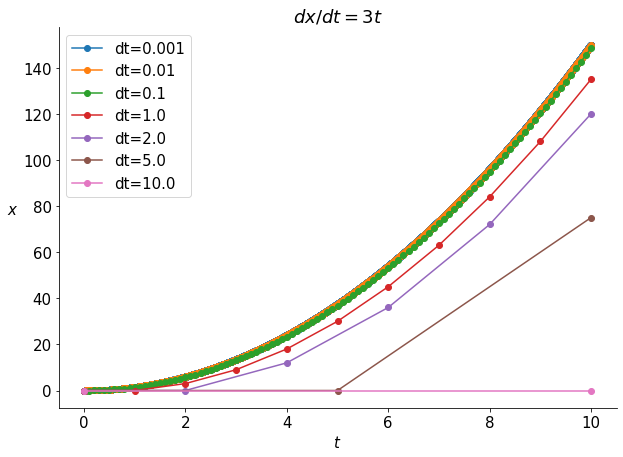

In [2]:
def dx(t, dt):
    assert t >= 0
    assert dt > 0
    return 3 * t * dt

max_time = 10
# delta_ts = [0.01, 0.02, 0.04, 0.08, 0.16]#, 0.32]#, 0.64]#, 1.28]
delta_ts = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]#, 0.32]#, 0.64]#, 1.28]
delta_ts = [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0]

for i, delta_t in enumerate(delta_ts):
    num_steps = int(max_time / delta_t) + 1
    x_approx = np.zeros(num_steps)
    for t in range(num_steps-1):
        x_approx[t+1] = x_approx[t] + dx(t*delta_t, delta_t)
    ticks = np.arange(num_steps) * delta_t
    plt.plot(ticks, x_approx, marker='o', label=f'dt={delta_t}')
    print(delta_t, x_approx[-1])

plt.title(r'$dx/dt = 3t$')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$', rotation=0, labelpad=10)
plt.legend()

### Analysing the effect of complex eigenvalues on convergence

$u(t) = c\,e^{\lambda t} x$

In [56]:
# x_1 = np.array([1, 0])
# x_2 = np.array([0, 1])
# c_1 = c2 = 1
c = 1
x = 1

def u_t(e_val, num_steps=10000):
    return np.array([c * np.exp(e_val * t) * x for t in range(num_steps)])

def plot_u_t(e_val, num_steps):
    u = u_t(e_val, num_steps)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cm = plt.get_cmap('winter')
    colors=[cm(i/num_steps) for i in range(num_steps)]
    ax.scatter(u.real, u.imag, c=colors)
    plt.xlabel('real')
    plt.ylabel('complex', rotation=0, labelpad=40)

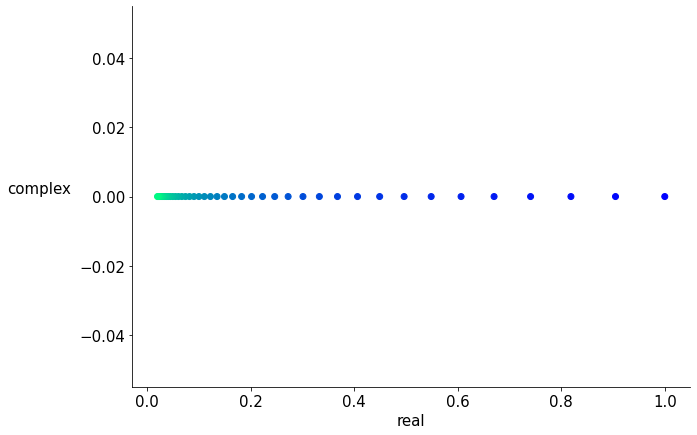

In [95]:
plot_u_t(-0.1, 40)

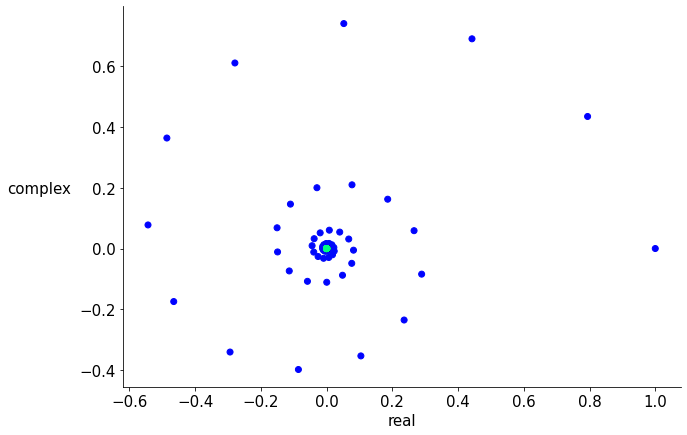

In [60]:
plot_u_t(-0.1 + 0.5j, 1000)

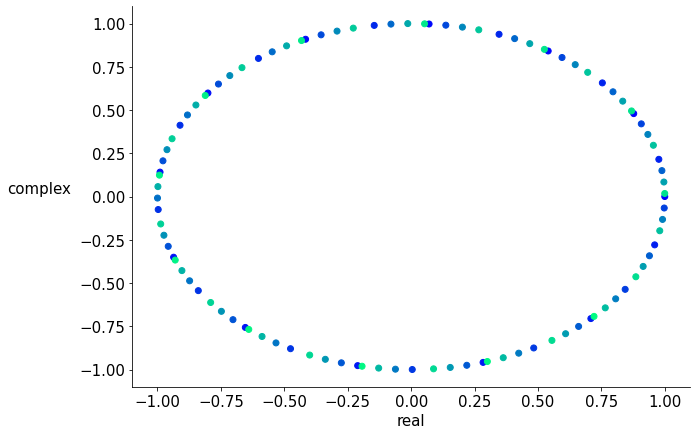

In [65]:
plot_u_t(0.5j, 100)

[Link](https://stackoverflow.com/questions/8500700/how-to-plot-a-gradient-color-line-in-matplotlib) in case I want to connect the points by lines

### Comparing concat and append

In [96]:
import timeit
a = np.zeros(5)
b = np.ones(5)
print(np.concatenate((a,b)))
print(np.append(a,b))

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


In [100]:
%%timeit
np.concatenate((a,b))

1.13 µs ± 1.69 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [101]:
%%timeit
np.append(a,b)

2.38 µs ± 61.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Timing multiple 1d-convolves over different runs vs a single 2d-convolve

In [88]:
from scipy.signal import convolve2d

location = '../average-reward-rl/results/unorganized/puckworld_t64_DiffQ_0.npy'
data = np.load(location, allow_pickle=True).item()
rewards = data['reward']
num_runs = rewards.shape[0]
max_run_length = rewards.shape[1]
window = 10000

def convolve_1d():
    conv_arr_1d = np.ones(window) / window
    reward_rate_all = np.zeros((num_runs, max_run_length - window + 1))
    for i, run in enumerate(range(rewards.shape[0])):
        reward_rate_all[i] = np.convolve(rewards[run,:], conv_arr_1d, mode='valid')
    return reward_rate_all 

def convolve_2d():
    conv_arr_2d = np.ones((1, window)) / window
    reward_rate_all = convolve2d(rewards, conv_arr_2d, mode='valid')
    return reward_rate_all

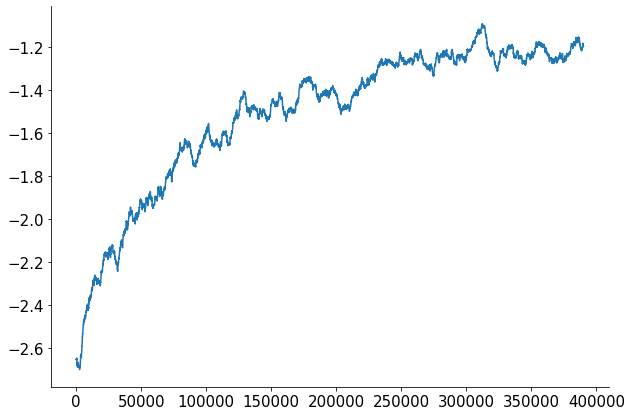

In [89]:
reward_rate_all = convolve_1d()
plt.plot(np.mean(reward_rate_all, axis=0))

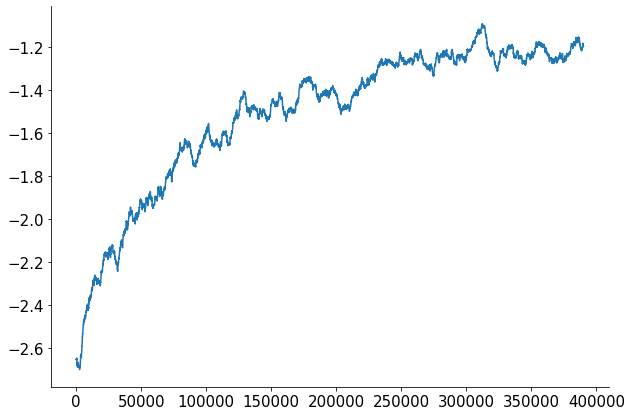

In [90]:
reward_rate_all = convolve_2d()
plt.plot(np.mean(reward_rate_all, axis=0))

In [91]:
%%timeit
convolve_1d()

2.57 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
%%timeit
convolve_2d()

20 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It is surprising that convolve2d is an order-of-magnitude slower than iterative 1d-convolve...

In [ ]:
reward_rate_all = convolve_1d()

## Checking effect of step sizes

In [46]:
def experiment(w_init=0, num_steps=100, alpha=0.01):
    w = w_init
    targets = [5, 10]
    log = {'w': np.zeros(num_steps+1),
           'error': np.zeros(num_steps+1),
           'alpha': alpha}
    log['w'][0] = w
    log['error'][0] = abs(targets[0] - w)
    
    for i in range(1, num_steps+1):
        target = targets[i % 2]
        delta = (target - w)
        w += alpha * delta
        log['w'][i] = w
        log['error'][i] = abs(delta)
    
    return log

def plot(results):
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    for alpha in results.keys():
        ax[0].plot(results[alpha]['error'], label=str(alpha))
        ax[1].plot(results[alpha]['w'], label=str(alpha))
    
    ax[0].set_xlabel('Time step')
    ax[0].set_ylabel('Absolute\nerror', rotation=0, labelpad=30)
    ax[0].legend()
    ax[0].axhline(y=2.5, alpha=0.3, color='black')
    
    ax[1].set_xlabel('Time step')
    ax[1].set_ylabel('w', rotation=0)
    ax[1].legend()
    ax[1].axhline(y=7.5, alpha=0.3, color='black')

In [53]:
alphas = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas[1:][::-1]:
    results[alpha] = experiment(alpha=alpha)

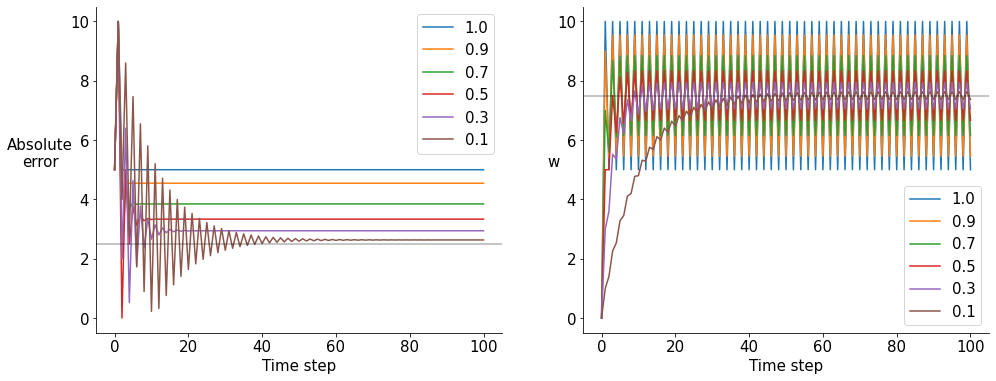

In [54]:
plot(results)